In [2]:
!pip install pytesseract 
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
try:
    from PIL import Image
except ImportError:
    import Image
#import pytesseract
#pytesseract.pytesseract.tesseract_cmd = "C:\Program Files (x86)\Tesseract-OCR\\tesseract.exe" 
#!sudo apt install tesseract-ocr
#pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

In [3]:
class CellDetector:
    """
    Class used to take the scanned image and detect the cells of a table

    ...

    Attributes
    ----------
    img : np.ndarray
        scanned image (expected an rgb image)
    
    Methods
    -------
    get_table_cells()
        returns an array of rows where each row has cols and each col consists of [x,y,w,h] 
        where [x,y,w,h] are the bounding boxes of the cells

        len(returnedArray) => number of rows
        len(returnedArray[0]) => number of cols 

    """

    def __init__(self,img,visualize=False):
      self.visualize=visualize
      gray_img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      self.img=gray_img
      thresh,img_bin = cv2.threshold(gray_img,115,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
      #inverting the image 
      img_bin = 255-img_bin
      self.img_bin = img_bin
      # Length(width) of kernel as 100th of total width
      kernel_len = np.array(img).shape[1]//100
      # Defining a vertical kernel to detect all vertical lines of image 
      self.ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
      # Defining a horizontal kernel to detect all horizontal lines of image
      self.hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
      # A kernel of 2x2
      self.kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

      if self.visualize:
        #Plotting the generated image
        plotting = plt.imshow(255-self.img_bin,cmap='gray')
        plt.show()

    def _sort_contours(self,cnts, method="left-to-right"):
      # initialize the reverse flag and sort index
      reverse = False
      i = 0
      # handle if we need to sort in reverse
      if method == "right-to-left" or method == "bottom-to-top":
          reverse = True
      # handle if we are sorting against the y-coordinate rather than
      # the x-coordinate of the bounding box
      if method == "top-to-bottom" or method == "bottom-to-top":
          i = 1
      # construct the list of bounding boxes and sort them from top to
      # bottom
      boundingBoxes = [cv2.boundingRect(c) for c in cnts]
      (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
      key=lambda b:b[1][i], reverse=reverse))
      # return the list of sorted contours and bounding boxes
      return (cnts, boundingBoxes)


    def get_table_cells(self):
      #Use vertical kernel to detect and save the vertical lines in a jpg
      image_1 = cv2.erode(self.img_bin, self.ver_kernel, iterations=3)
      vertical_lines = cv2.dilate(image_1, self.ver_kernel, iterations=3)

      if self.visualize:
        #Plotting the generated image
        plotting = plt.imshow(vertical_lines,cmap='gray')
        plt.show()

      #Use horizontal kernel to detect and save the horizontal lines in a jpg
      image_2 = cv2.erode(self.img_bin, self.hor_kernel, iterations=3)
      horizontal_lines = cv2.dilate(image_2, self.hor_kernel, iterations=3)

      if self.visualize:
        #Plotting the generated image
        plotting = plt.imshow(horizontal_lines,cmap='gray')
        plt.show()

      # Combine horizontal and vertical lines in a new third image, with both having same weight.
      img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)

      #Eroding and thesholding the image
      img_vh = cv2.erode(~img_vh, self.kernel, iterations=2)
      thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
      
      bitxor = cv2.bitwise_xor( cv2.bitwise_xor(self.img_bin,horizontal_lines),vertical_lines)
      bitnot = cv2.bitwise_not(bitxor)
      # thresh,bitnot = cv2.threshold(bitnot,170,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)

      if self.visualize:
        #Plotting the generated image
        plotting = plt.imshow(img_vh,cmap='gray')
        plt.show()

      # Detect contours for following box detection
      contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      # Sort all the contours by top to bottom.
      contours, boundingBoxes = self._sort_contours(contours, method="top-to-bottom")
      
      #Creating a list of heights for all detected boxes
      heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
      #Get mean of heights
      mean = np.mean(heights)
      #Create list box to store all boxes in  
      box = []
      # Get position (x,y), width and height for every contour and show the contour on image
      for c in contours:
          x, y, w, h = cv2.boundingRect(c)
          if (w<1000 and (h<500 and h>10)):
              image = cv2.rectangle(self.img,(x,y),(x+w,y+h),(0,255,0),2)
              box.append([x,y,w,h])

      #Creating two lists to define row and column in which cell is located
      row=[]
      column=[]
      j=0

      #Sorting the boxes to their respective row and column
      for i in range(len(box)):    
              
          if(i==0):
              column.append(box[i])
              previous=box[i]    
          
          else:
              if(box[i][1]<=previous[1]+mean/2):
                  column.append(box[i])
                  previous=box[i]            
                  
                  if(i==len(box)-1):
                      row.append(column)        
                  
              else:
                  row.append(column)
                  column=[]
                  previous = box[i]
                  column.append(box[i])
                  

      #calculating maximum number of cells
      countcol = 0
      for i in range(len(row)):
          countcol = len(row[i])
          if countcol > countcol:
              countcol = countcol

      #Retrieving the center of each column
      center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]

      center=np.array(center)
      center.sort()
      #Regarding the distance to the columns center, the boxes are arranged in respective order

      finalboxes = []
      for i in range(len(row)):
          lis=[]
          for k in range(countcol):
              lis.append([])
          for j in range(len(row[i])):
              diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
              minimum = min(diff)
              indexing = list(diff).index(minimum)
              lis[indexing].append(row[i][j])
          finalboxes.append(lis)
      return finalboxes, bitnot # return the cells and an enhanced image

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.filters import threshold_local
import imutils

def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)




class Scanner:
    """
    Class used to take captured image and transform it to scanned

    ...

    Attributes
    ----------
    img : np.ndarray
        image to be scanned
    original : np.ndarray
        original copy of the image kept for visualizing
    GAUSSIAN_SIZE : tuple
        Window size of gaussian filter
    CANNY_L_THRESH : int
        Low threshold of canny edge detector
    CANNY_H_THRESH : int
        High threshold of canny edge detector
    DILATION_SIZE : tuple
        Element size of dilation
    DILATION_ITERS : int
        Number of dilations
    EROSION_SIZE : tuple
        Element size of erosion
    EROSION_ITERS : int
        Number of erosions
    
    Methods
    -------
    get_edges()
        return an image wiht edges of original

    get_corners(edged)
        return return the corners of the scanned paper

    order_pts(pts)
        return an ordered version of the corners (top-left,top-right,bottom-right,bottom-left)

    get_dst_pts(rect)
        return the new dimension points for the scanned image
    
    trnasform(visualize=True)
        return the transfomed scanned paper
    """

    def __init__(self,img,GAUSSIAN_SIZE=(9,9),CANNY_L_THRESH=75,CANNY_H_THRESH=170,DILATION_SIZE=(5,5),DILATION_ITERS=5,EROSION_SIZE=(5,5),EROSION_ITERS=1):
        self.img = img.copy()
        self.original = img.copy()
        self.GAUSSIAN_SIZE = GAUSSIAN_SIZE
        self.CANNY_L_THRESH = EROSION_ITERS
        self.CANNY_H_THRESH = CANNY_H_THRESH
        self.DILATION_SIZE = DILATION_SIZE
        self.DILATION_ITERS = DILATION_ITERS
        self.EROSION_SIZE = EROSION_SIZE
        self.EROSION_ITERS = EROSION_ITERS

    def get_edges(self):
        gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, self.GAUSSIAN_SIZE, 0)
        edged = cv2.Canny(gray, self.CANNY_L_THRESH, self.CANNY_H_THRESH)
        edged = cv2.dilate(edged,self.DILATION_SIZE,iterations=self.DILATION_ITERS)
        edged = cv2.erode(edged,self.EROSION_SIZE,iterations=self.EROSION_ITERS)

        return edged

    def get_corners(self,edged):
        cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

        for c in cnts:

            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)

            if len(approx) >= 4:
                corners = approx
                break
        
        return corners

    def order_pts(self,pts):
        rect_pts = np.zeros((4, 2), dtype = "float32")
        s = pts.sum(axis = 1)
        rect_pts[0] = pts[np.argmin(s)]
        rect_pts[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis = 1)
        rect_pts[1] = pts[np.argmin(diff)]
        rect_pts[3] = pts[np.argmax(diff)]
        
        return rect_pts

    def get_dst_pts(self,rect):
        (tl, tr, br, bl) = rect

        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))

        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))

        dst = np.array([
            [0, 0],
            [maxWidth - 1, 0],
            [maxWidth - 1, maxHeight - 1],
            [0, maxHeight - 1]], dtype = "float32")

        return dst
    
    def trnasform(self,visualize=True):
        
        edged = self.get_edges()
        corners = self.get_corners(edged)
        ordered_corners = self.order_pts(corners.reshape(-1,2))
        transformed_corners = self.get_dst_pts(ordered_corners)
        H = cv2.getPerspectiveTransform(ordered_corners, transformed_corners)
        transformed = cv2.warpPerspective(self.original, H, (int(transformed_corners[2][0]+1), int(transformed_corners[2][1]+1)))

        if visualize:
            plt.figure(0)
            plt.imshow(self.original)
            plt.figure(1)
            plt.imshow(edged)
            cv2.drawContours(self.img, [corners], -1, (0, 255, 0), 15)
            plt.figure(2)
            plt.imshow(self.img)
            plt.figure(3)
            plt.imshow(transformed)
        return transformed

In [5]:
def removeShadow(img):
  rgb_planes = cv2.split(img)

  result_planes = []
  result_norm_planes = []
  for plane in rgb_planes:
      dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
      bg_img = cv2.medianBlur(dilated_img, 21)
      diff_img = 255 - cv2.absdiff(plane, bg_img)
      norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
      result_planes.append(diff_img)
      result_norm_planes.append(norm_img)

  result = cv2.merge(result_planes)
  result_norm = cv2.merge(result_norm_planes)
  return result

In [6]:
# cells_image= image returned from the CellDetector, finalboxes= cells,output_path=path of the csv file
def output_csv(cells_image,finalboxes,output_path,cols_to_drop=[]): 
  #from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
  outer=[]
  codeImages=[]
  for i in range(len(finalboxes)):
      for j in range(len(finalboxes[i])):
          inner=''
          if j not in cols_to_drop:
            if(len(finalboxes[i][j])==0):
                outer.append(' ')
            else:
                for k in range(len(finalboxes[i][j])):
                    x,y,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                    finalimg = cells_image[ y:y+h,x:x +w]
                    cropHeight= int(0.1*finalimg.shape[0])
                    cropWidth= int(0.03*finalimg.shape[1])
                    finalimg=finalimg[cropHeight:-cropHeight,cropWidth:-cropWidth]

                    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                    border = cv2.copyMakeBorder(finalimg,2,2,2,2, cv2.BORDER_CONSTANT,value=[255,255])
                    resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                    dilation = cv2.dilate(resizing, kernel,iterations=1)
                    erosion = cv2.erode(dilation, kernel,iterations=2)

                    #for debugging 
                    if j==0:
                      codeImages.append(erosion)
                    #end of for debugging
                    options = "outputbase digits"
                    out = pytesseract.image_to_string(erosion,config=options) 
                    # ,lang='eng',
                    #   config='--psm 13 --oem 3 -c tessedit_char_whitelist=0123456789'
                    out=out.replace("\n","").replace("|","").replace("_","").replace("[","").strip()
                 
                    inner = inner +" "+ out
                outer.append(inner)

  #Creating a dataframe of the generated OCR list
  arr = np.array(outer)
  dataframe = pd.DataFrame(arr.reshape(len(finalboxes), len(finalboxes[0])-len(cols_to_drop)))
  dataframe.reset_index(drop=True, inplace=True)
  data = dataframe.style.set_properties(align="left")
  data.to_excel(output_path, index=False)
  show_images(images=codeImages)
  print(dataframe)
  return codeImages

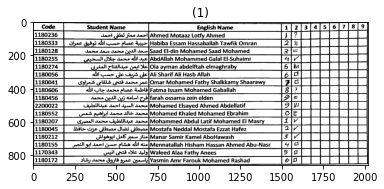

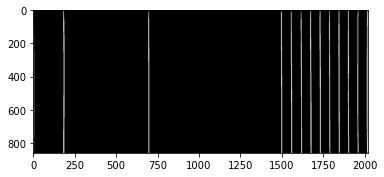

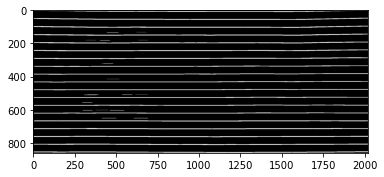

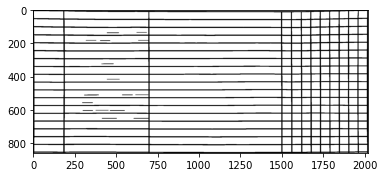

NameError: name 'pytesseract' is not defined

In [10]:

img = cv2.imread("../datasets/grade_papers/5.jpg")
#remove the shadow
img=removeShadow(img)
show_images([img])
#scan the image
sc = Scanner(img)
scanned = sc.trnasform(visualize=False)
#detect the cells
cellDetector=CellDetector(scanned,visualize=True)
cells,cells_image=cellDetector.get_table_cells()
cols_to_drop=[1,2]
codeImages=output_csv(cells_image,cells,"/content/output.xlsx",cols_to_drop)

18
13


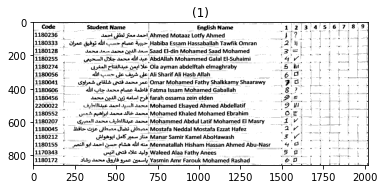

In [11]:
show_images([cells_image])
print(len(cells))
print(len(cells[0]))

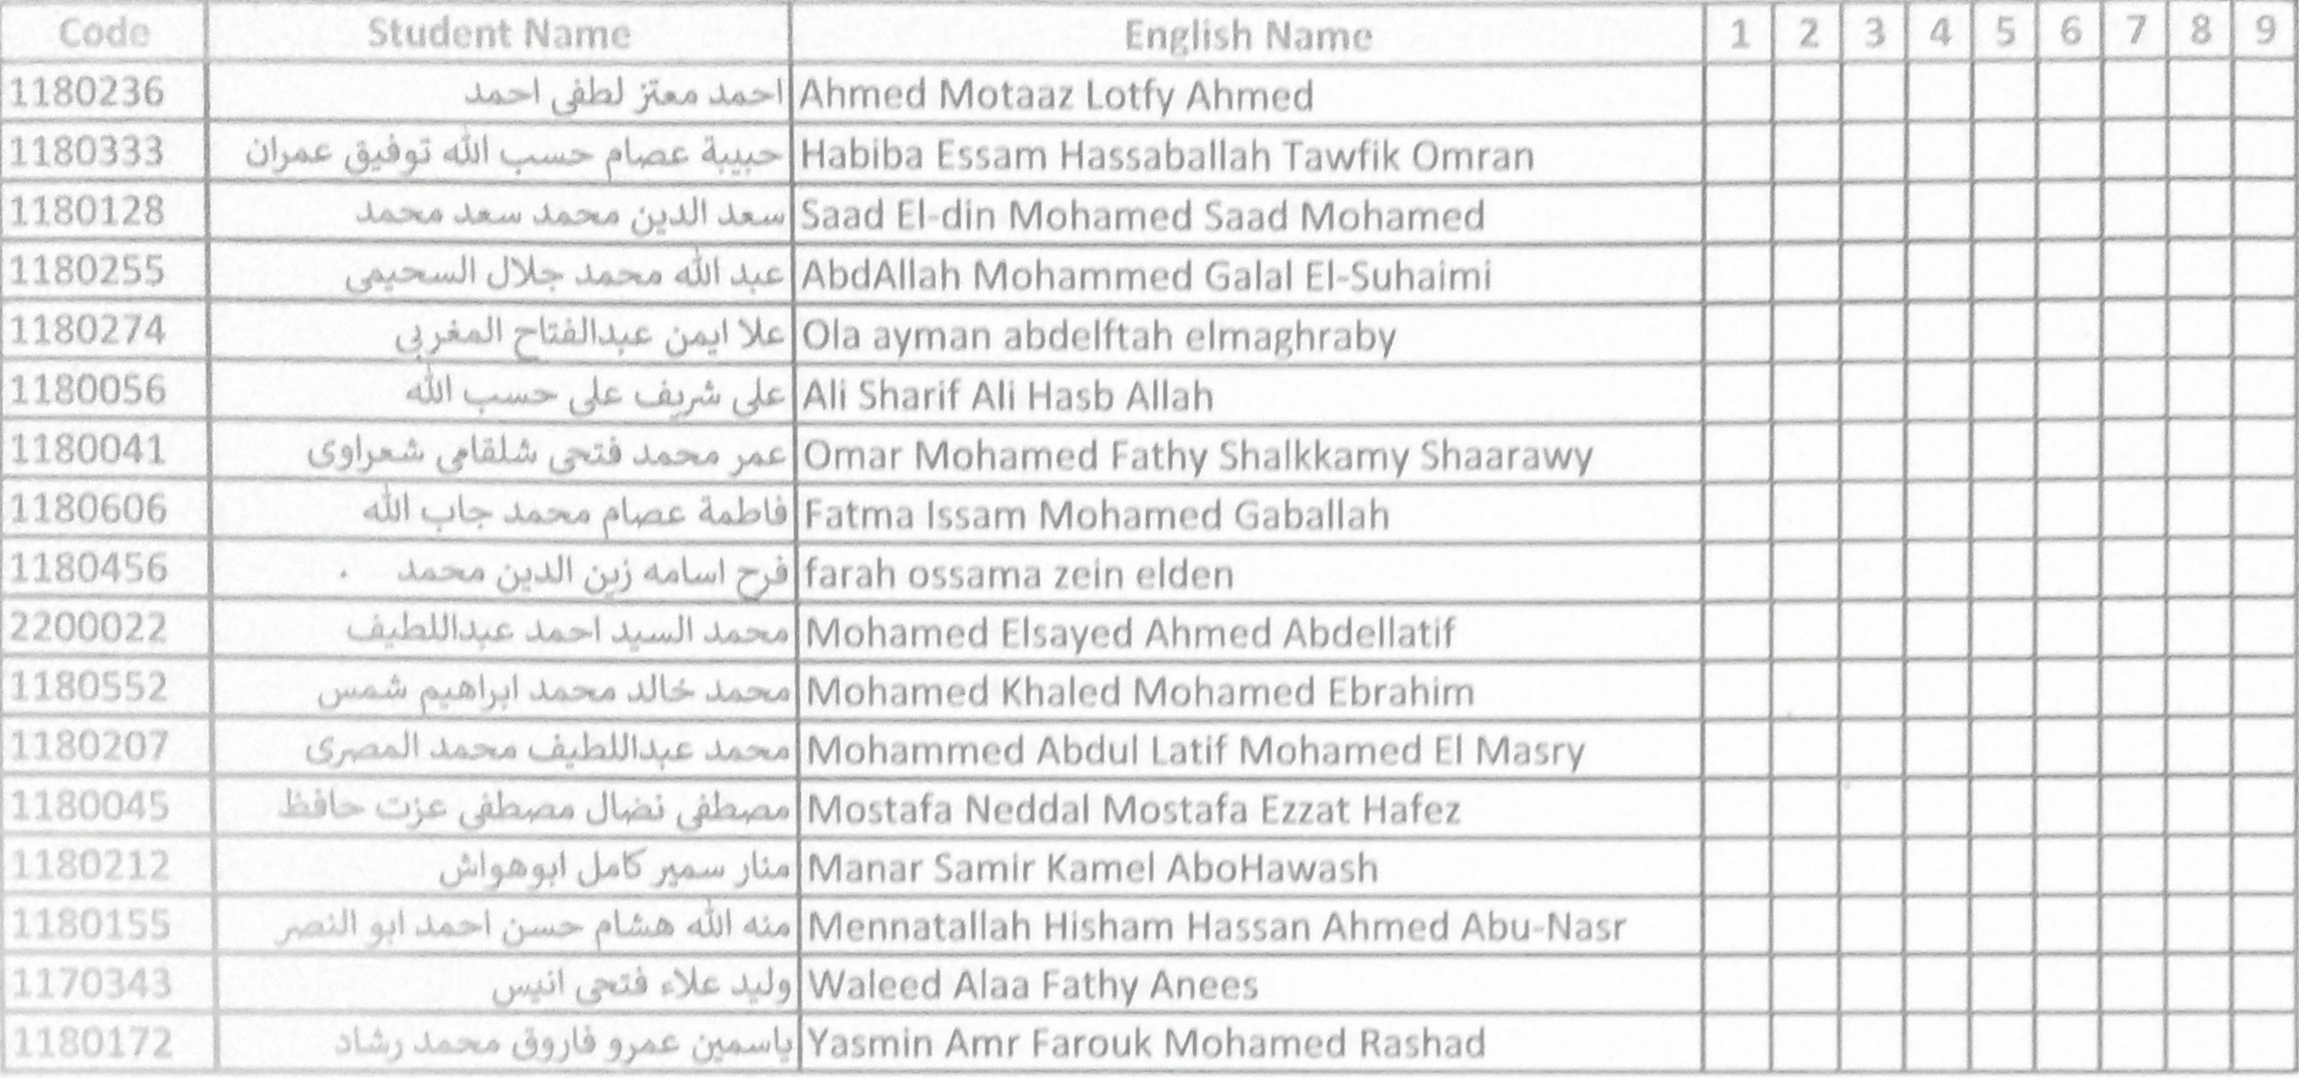

In [178]:
# show_images([img])
from google.colab.patches import cv2_imshow
cv2_imshow(scanned)

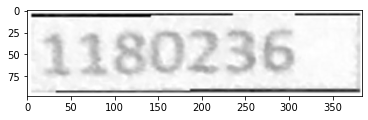

In [139]:
# blur = cv2.GaussianBlur(codeImages[1],(5,5),0)
# _,thresh =  cv2.threshold(codeImages[1].copy(), 240, 255,cv2.THRESH_BINARY_INV)
cnts = cv2.findContours(codeImages[1].copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
digit_bb = []
# loop over the digit area candidates
vis_img=thresh.copy()
for c in cnts:
    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)
    # if the contour is sufficiently large, it must be a digit
    if w >= 0 and (h >= 0 and h <= 800):
        digit_bb.append([x, y, w, h])
        cv2.drawContours(vis_img, [c], -1, (0, 255, 0), 15)

plt.imshow(codeImages[1])